In [ ]:
!nvidia-smi

Thu Aug 12 12:55:27 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pwd

/content


In [ ]:
!ls

sample_data  training.json  train.zip


In [ ]:
cd drive/

In [ ]:
#Install detectron2
#!pip uninstall torch==1.9
#!pip install -U torch==1.5 torchvision
#!pip install git+https://github.com/facebookresearch/fvcore.git
import torch, torchvision
torch.__version__

'1.5.0'

In [ ]:
# install detectron2:
!pip install detectron2==0.1.3 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html
     |████████████████████████████████| 6.2 MB 5.5 MB/s 


In [ ]:
torch.__version__

'1.5.0'

In [ ]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import matplotlib.pyplot as plt
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [ ]:
!unzip train.zip

Archive:  train.zip
   creating: train/
  inflating: train/desktop.ini       
  inflating: train/IM-0115-0001.jpeg  
  inflating: train/IM-0115-0001.json  
  inflating: train/IM-0117-0001.jpeg  
  inflating: train/IM-0117-0001.json  
  inflating: train/IM-0119-0001.jpeg  
  inflating: train/IM-0119-0001.json  
  inflating: train/IM-0122-0001.jpeg  
  inflating: train/IM-0122-0001.json  
  inflating: train/IM-0125-0001.jpeg  
  inflating: train/IM-0125-0001.json  
  inflating: train/IM-0127-0001.jpeg  
  inflating: train/IM-0127-0001.json  
  inflating: train/IM-0128-0001.jpeg  
  inflating: train/IM-0128-0001.json  
  inflating: train/IM-0129-0001.jpeg  
  inflating: train/IM-0129-0001.json  
  inflating: train/IM-0131-0001.jpeg  
  inflating: train/IM-0131-0001.json  
  inflating: train/IM-0133-0001.jpeg  
  inflating: train/IM-0133-0001.json  
  inflating: train/IM-0135-0001.jpeg  
  inflating: train/IM-0135-0001.json  
  inflating: train/IM-0137-0001.jpeg  
  inflating: train/IM-013

In [ ]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("final_seg_model1", {}, "./training.json", "./train")

In [ ]:
sample_metadata = MetadataCatalog.get("final_seg_model1")
dataset_dicts = DatasetCatalog.get("final_seg_model1")

WARNING [08/12 13:12:55 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/12 13:12:55 d2.data.datasets.coco]: Loaded 174 images in COCO format from ./training.json


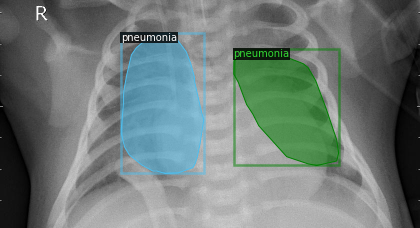

In [ ]:
import random

for d in random.sample(dataset_dicts, 4):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=sample_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

In [ ]:
!git clone https://github.com/facebookresearch/detectron2 detectron2_repo

Cloning into 'detectron2_repo'...
remote: Enumerating objects: 12800, done.
remote: Counting objects: 100% (298/298), done.
remote: Compressing objects: 100% (175/175), done.
remote: Total 12800 (delta 140), reused 240 (delta 121), pack-reused 12502
Receiving objects: 100% (12800/12800), 5.48 MiB | 14.91 MiB/s, done.
Resolving deltas: 100% (9096/9096), done.


In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os
#https://github.com/facebookresearch/detectron2/blob/master/MODEL_ZOO.md
cfg = get_cfg()
cfg.merge_from_file("./detectron2_repo/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.DATASETS.TRAIN = ("final_seg_model1",)
cfg.DATASETS.TEST = ()   # no metrics implemented for this dataset
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = "https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl"  # initialize from model zoo
#https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.02
cfg.SOLVER.MAX_ITER = 10000    # 300 iterations seems good enough, but you can certainly train longer
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 14  # 3 classes (Person, Helmet, Car)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[08/12 13:13:45 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f10217.pkl: 178MB [00:02, 60.6MB/s]                           
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (15, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (15,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (56, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (56,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due 

[08/12 13:13:50 d2.engine.train_loop]: Starting training from iteration 0
[08/12 13:13:59 d2.utils.events]:  eta: 1:08:01  iter: 19  total_loss: 3.627  loss_cls: 2.012  loss_box_reg: 0.826  loss_mask: 0.692  loss_rpn_cls: 0.012  loss_rpn_loc: 0.021  time: 0.4129  data_time: 0.0218  lr: 0.000400  max_mem: 2617M
[08/12 13:14:07 d2.utils.events]:  eta: 1:10:07  iter: 39  total_loss: 1.934  loss_cls: 0.567  loss_box_reg: 0.800  loss_mask: 0.601  loss_rpn_cls: 0.010  loss_rpn_loc: 0.013  time: 0.4229  data_time: 0.0058  lr: 0.000799  max_mem: 2617M
[08/12 13:14:16 d2.utils.events]:  eta: 1:11:57  iter: 59  total_loss: 1.558  loss_cls: 0.347  loss_box_reg: 0.624  loss_mask: 0.438  loss_rpn_cls: 0.011  loss_rpn_loc: 0.015  time: 0.4263  data_time: 0.0048  lr: 0.001199  max_mem: 2617M
[08/12 13:14:25 d2.utils.events]:  eta: 1:12:11  iter: 79  total_loss: 1.343  loss_cls: 0.322  loss_box_reg: 0.575  loss_mask: 0.393  loss_rpn_cls: 0.004  loss_rpn_loc: 0.011  time: 0.4326  data_time: 0.0066  lr:

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
cfg.DATASETS.TEST = ("final_seg_model1", )
predictor = DefaultPredictor(cfg)

(784, 1280, 3)
tensor([1, 1], device='cuda:0')


(1608, 1882, 3)
tensor([1, 1, 1, 0], device='cuda:0')


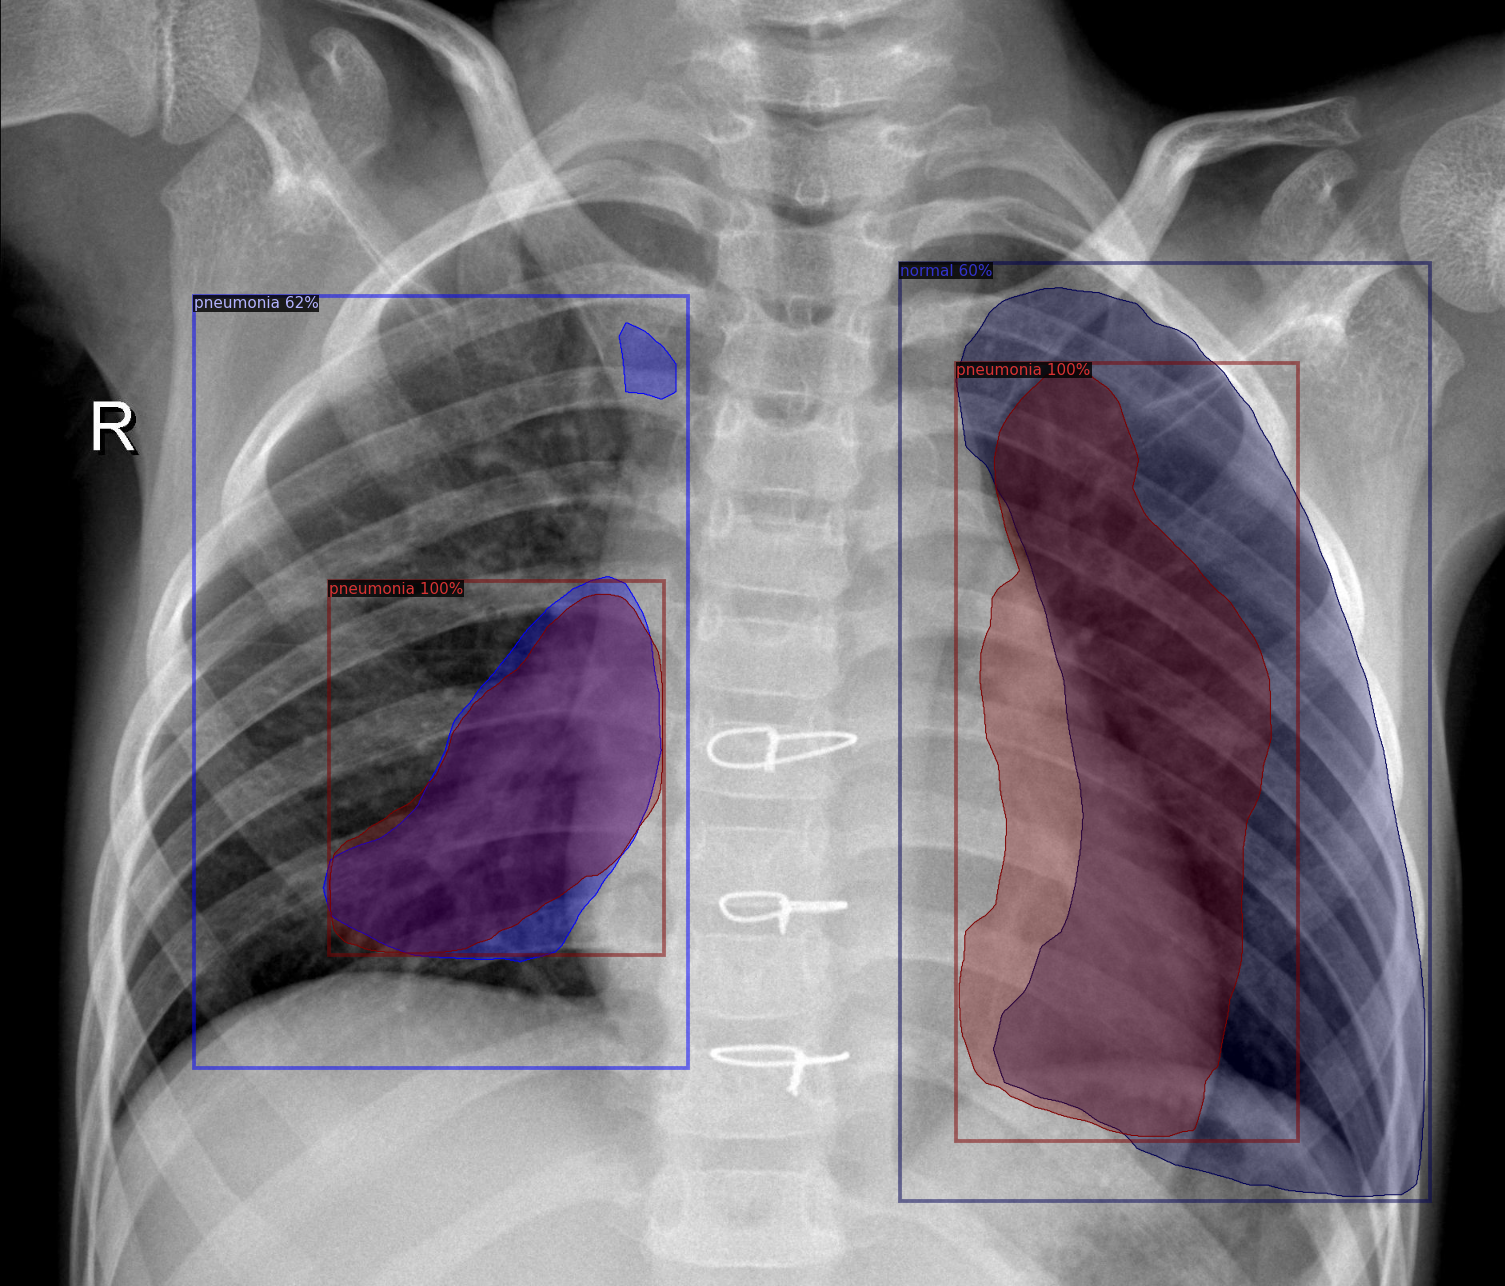

(940, 1242, 3)
tensor([1, 1], device='cuda:0')


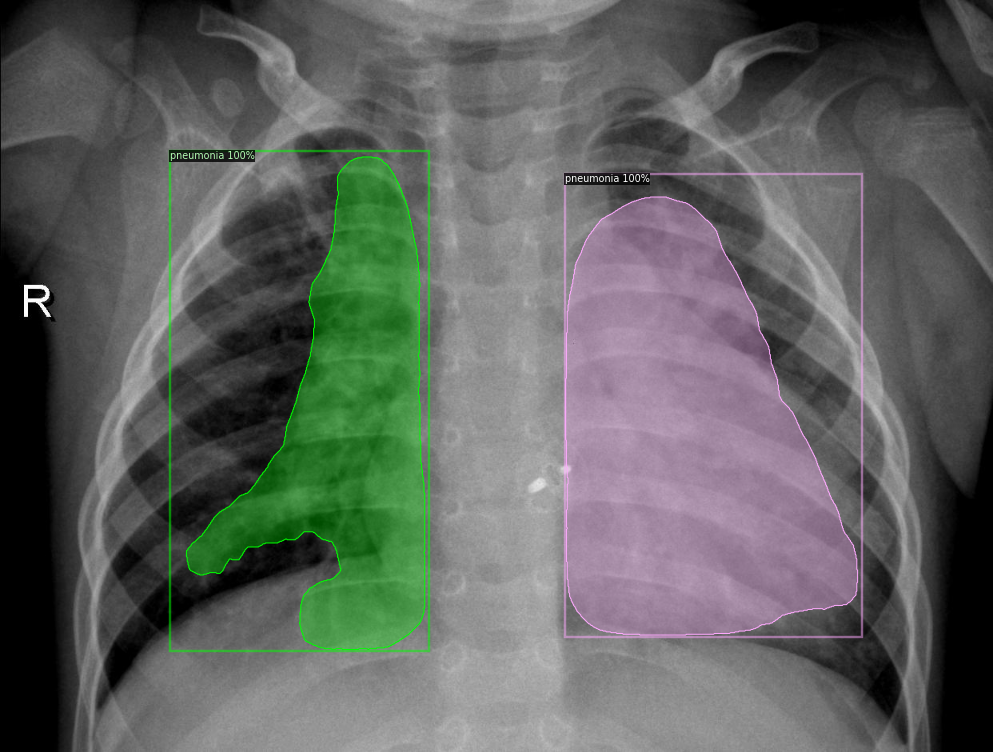

(1124, 1646, 3)
tensor([0, 1, 0, 1], device='cuda:0')


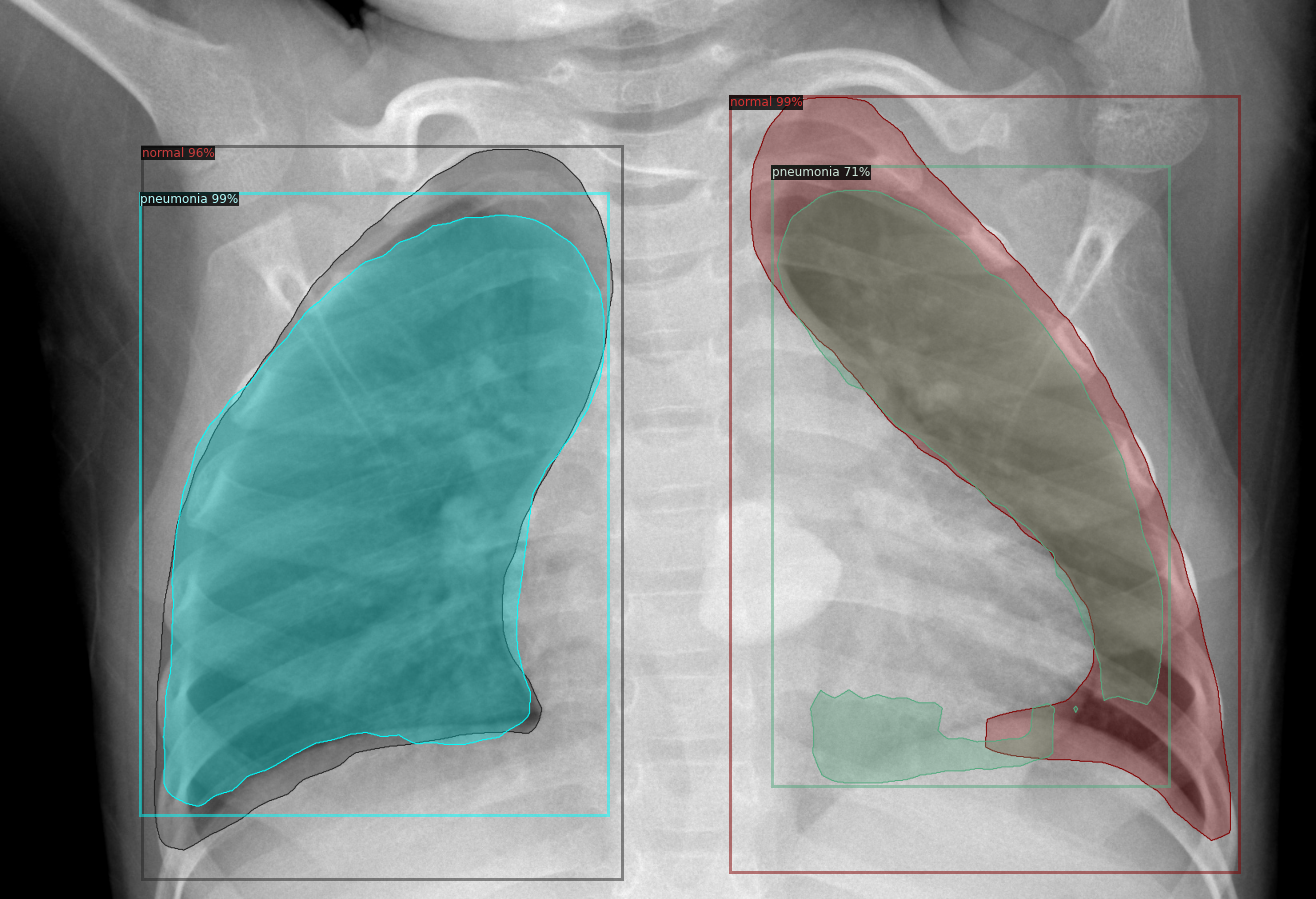

In [ ]:
from detectron2.utils.visualizer import ColorMode

for d in random.sample(dataset_dicts, 4):    
    im = cv2.imread(d["file_name"])
    print(im.shape)
    outputs = predictor(im)
    print(outputs['instances'].pred_classes)
    v = Visualizer(im[:, :, ::-1],
                   metadata=sample_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    if 1 in outputs['instances'].pred_classes: 
      cv2_imshow(v.get_image()[:, :, ::-1])

In [ ]:
import os
print(os.listdir('/content/test_data'))

['.ipynb_checkpoints', 'person59_virus_116.jpeg', 'IM-0035-0001.jpeg']


In [ ]:
!rm -r '/content/test_data/.ipynb_checkpoints'

(616, 1072, 3)
<class 'detectron2.structures.instances.Instances'>
(2329, 2480, 3)
<class 'detectron2.structures.instances.Instances'>


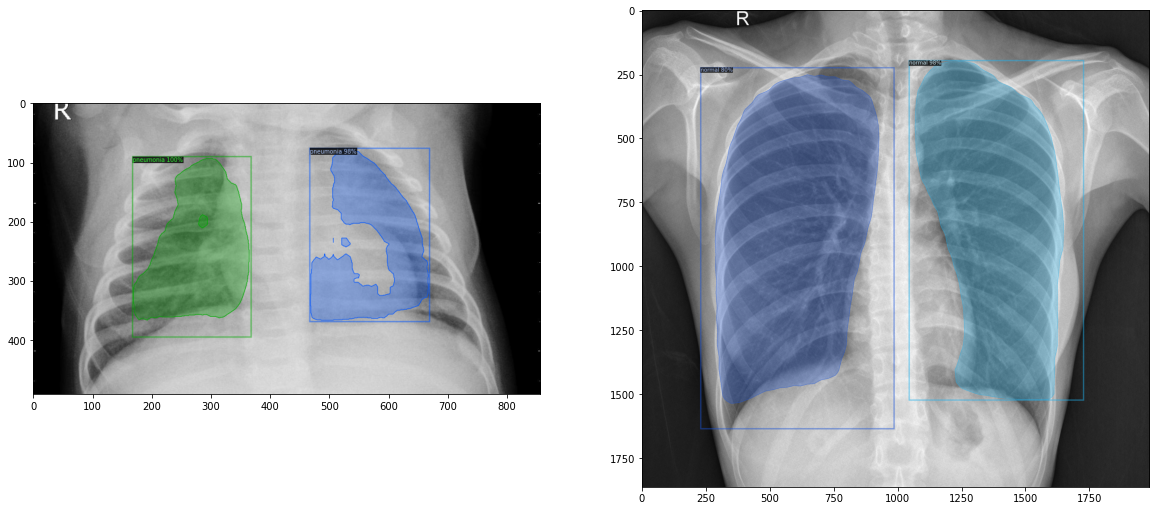

In [ ]:
from detectron2.utils.visualizer import ColorMode
import matplotlib.pyplot as plt
root = '/content/test_data'
fig,ax = plt.subplots(1,2,figsize=(20,20))
#fig.figure(figsize=(20,20))
for c,d in enumerate(os.listdir('/content/test_data')):    
    im = cv2.imread(os.path.join(root,d))
    print(im.shape)
    outputs = predictor(im)
    print(type(outputs['instances']))
    v = Visualizer(im[:, :, ::-1],
                   metadata=sample_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    
    ax[c].imshow(v.get_image()[:, :, ::-1])
plt.show()

In [ ]:
model_loaded = torch.load('/content/output/model_final.pth')